In [1]:
import numpy as np
import cldnufuncs as cfunc
import matplotlib.pyplot as plt
import spherical_bin as sp
import window as win
import pkfuncs as pfunc

In [2]:
path = '.' # path to the Gridded visibilities.


Ncores = 20
Nmg = 10 # Number of realizations for Mg

# inputs
nc = 10 # nc is always used for total channels
NC = 1 # no. of channels to collapse
xn = 0 # no. of grids to exclude from from each sides of the gridded data.
na = nc//NC # No. of channels available after collapse.

# header
headersize = (nc+3)*np.float64().itemsize
hinfo = cfunc.read_header(str(path)+'/GV-data', headersize, nc)
hinfo = np.asarray(hinfo, dtype='object')
np.save(str(path)+'/hinfo', hinfo)



In [3]:
# eg    
eg1 = cfunc.func_cldnu_multi(str(path)+'/GV-data', nc, NC, xn, Ncores) 
np.save(str(path)+'/eg', eg1) # unnormalized estimate, can be normalized with Mg.

print('eg estimated. \n')

eg estimated. 



In [4]:
# Mg, save the GV-mg as GV-mg-1, GV-mg-2 etc. 

mg = np.zeros_like(eg1)

for ii in range(Nmg):
    mg += cfunc.func_cldnu_multi(str(path)+'/GV-mg-'+str(ii+1), nc, NC, xn, Ncores)
    print('Mg done for Re '+str(ii+1))
mg /= Nmg
np.save(str(path)+'/mg', mg) # unnormalized estimate, can be normalized with Mg.
print('Mg estimated. \n')

Mg done for Re 1
Mg done for Re 2
Mg done for Re 3
Mg done for Re 4
Mg done for Re 5
Mg done for Re 6
Mg done for Re 7
Mg done for Re 8
Mg done for Re 9
Mg done for Re 10
Mg estimated. 



In [5]:
# # 1. Noise in a grid: estimate noise in a grid for all realizations and save them
# Nnoise = 10 # Number of realizations for noise.
# for ii in range(Nnoise):
#     egn = cfunc.func_cldnu_multi(str(path)+'/GV-noise-'+str(ii+1), nc, NC, xn, Ncores)
#     np.save(str(path)+'/eg-noise/egn-'+str(ii+1), egn) # unnormalized estimate, can be normalized with Mg.
#     print('Noise done for Re '+str(ii+1)) # kept at a directory "eg-noise"

# print('Noise estimated in grids. \n')


# cl and PS calculations

In [6]:
FWHM, dUg, f, nua = np.load('./hinfo.npy', allow_pickle=True)
eg = np.load('./eg.npy')
mg = np.load('./mg.npy') # mg = 800 Nrea. 

# eg to cl, binning parameters 
U1, U2, NBin = 0, 400, 4

# binning
el = cfunc.func_bincl(eg, dUg, U1, U2, NBin)
ml = cfunc.func_bincl(mg, dUg, U1, U2, NBin)
cl = el/ml # estimated cl (in a bin)


# # 2. Noise in a bin: read each realization from grid, bin them individually
# cln1 = np.zeros((Nrea, NBin, nc))
# for ii in range(Nnoise):
#     eln = np.load(str(path)+'/eg-noise/egn-'+str(ii+1)+'.npy')
#     cln1[ii] = cfunc.func_bincl(eln, dUg, U1, U2, NBin)/ml # normalized
# cln = np.std(cln1, axis=0)/np.sqrt(Nnoise)
cln = np.ones((NBin, nc)) # unit noise (when you have no noise estimates)

lb = cfunc.mk_lin_bin(mg, dUg, U1, U2, NBin)[0]*2.*np.pi # estimated ell (in a bin)
ell = np.intc(lb)
nell = len(ell)

clinfo = np.empty(3, dtype='object')
clinfo[:3] = cl, cln, lb
np.save('clinfo.npy', clinfo) # all you need for PS

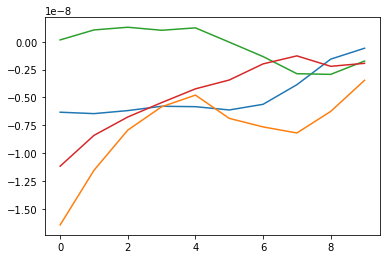

In [7]:
for ii in range(nell):
    plt.plot(cl[ii])

# PS

In [9]:
# read cl
cl, cln, lb = np.load('clinfo.npy', allow_pickle='True') # cl, cl-error, ell
FWHM, dUg, f, nua = np.load('./hinfo.npy', allow_pickle=True)


In [10]:
# CL 

nc = cl.shape[-1]
nuc = nua.mean()/1e6 # nu_c
dnuc = abs(nua[1]-nua[0])/1e6 # delta-nu-c MHz
dnu = np.arange(nc)*dnuc # MHz
ell = np.intc(lb)
nell = len(ell)

# PS
r, rp = 5703, 9.85 # Mpc (Planck 2018) # z = 2.28
fac = r/(rp*nuc) # wedge boundary: kpara_H = fac*kper 
dkl = np.ones(nell)*1. # fixed buffer
# dkl[:] = np.array([0.5, 1.4, 1.0, 1.3, 0.02, 1., 1., 1., 1.2, 1.2]) #  # individual buffer for a kper-bin

vfac = rp*r*r*dnuc*(nc-1) # DCT factor 
kper = ell/r
kpara = 2.*np.pi*np.arange(nc)/(rp*(2.*nc-2.)*dnuc)
covi = 1/cln**2 # noise variance inverse 


# window for Fourier transform
w = win.window('BN', np.arange(nc))


In [11]:
pk = pfunc.func_pk(cl, w, covi, vfac) # MLE cylindrical PS P(kper, kpara) estimation


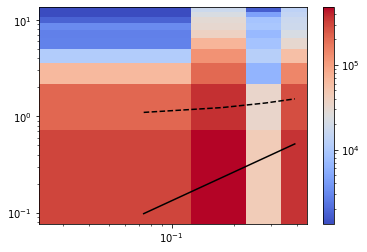

In [12]:
# A not-so-decent plot of cylindrical PS
from matplotlib.colors import LogNorm
y, x = np.meshgrid(kpara, kper)
plt.pcolormesh(x, y, abs(pk)*1e6, norm = LogNorm(), shading='auto', cmap='coolwarm')
plt.colorbar()

plt.xscale('log')
plt.yscale('log')
plt.plot(kper, fac*kper, 'k-')
plt.plot(kper, fac*kper + dkl, 'k--')

In [ ]:
# Spherically averaged PS (Not MLE) 
NB = 6 # spherial bins
pks, kb, num = binpk(pk,kper,kpara,dkl,fac,NB)

In [ ]:
# Spherical PS (MLE, Elahi et al. 2023 (under review))

AM, kk = sp.calc_AM(kper,kpara,dkl,fac,NB)

# covi = np.ones((nell, nc))
X, COV1 = sp.func_PE(AM, cl.flatten(), np.diag(covi.flatten()), NB, vfac) # p and COV
pp, COV = X[:NB], COV1[:NB, :NB]

# upper-limit
dTC1, ddTC1, ulC1 = sp.func_dT(kk, pp, COV) # 
kk,  np.sqrt(dTC1), np.sqrt(ddTC1), np.sqrt(ulC1), dTC1/ddTC1 # SNR
